# Setup

In [1]:
"""
Add parent directorys to current path
"""
import os.path
import sys

"""
Add gym-hiring directory to current path. I believe this is needed
when referencing a pip "file:///" dependency.
"""
p = os.path.abspath('../')
if p not in sys.path:
    sys.path.insert(0, p)

import gym
import gym_hiring
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from experiments.utils import play_episode, plot_running_avg, running_avg

# Define Optimal Policy

In [2]:
class OptimalFairHiringPolicy:
    
    def __init__(self, gender_95):
        self.gender_95 = gender_95
    
    def select_action(self, obs, eps):
        gender = obs[0]
        prod_score = obs[1][0]
        
        # Hiring threshold is set to the 95th percentile of each
        # gender's Productivy Score.
        thresh = self.gender_95[gender]
            
        if prod_score >= thresh:
            return 1
        else:
            return 0
    
    def add_experience(self, prev_obs, action, reward, obs, done):
        pass
    
    def train(self, iters):
        pass

# Execute Optimal Policy

episode: 0, total reward: 0.24, eps: 1.000, avg reward last 500: 0.245
episode: 500, total reward: 0.49, eps: 0.288, avg reward last 500: 0.279
episode: 1,000, total reward: 0.39, eps: 0.251, avg reward last 500: 0.282
episode: 1,500, total reward: 0.33, eps: 0.232, avg reward last 500: 0.287
episode: 2,000, total reward: 0.27, eps: 0.219, avg reward last 500: 0.282
episode: 2,500, total reward: 0.31, eps: 0.209, avg reward last 500: 0.288
episode: 3,000, total reward: 0.08, eps: 0.202, avg reward last 500: 0.292
episode: 3,500, total reward: 0.36, eps: 0.196, avg reward last 500: 0.290
episode: 4,000, total reward: 0.25, eps: 0.190, avg reward last 500: 0.292
episode: 4,500, total reward: 0.21, eps: 0.000, avg reward last 500: 0.279

Total steps: 5,000
Avg cumulative reward: 0.286
Avg reward for last 500 episodes: 0.289


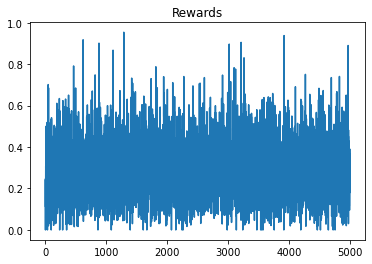

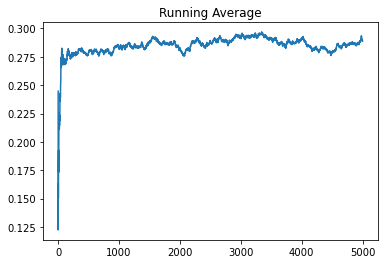

In [3]:
MEN_LOW = .3
MEN_HIGH = 1
WOM_LOW = .25
WOM_HIGH = .95

men_95th = (.95*(MEN_HIGH - MEN_LOW))+ MEN_LOW
wom_95th = (.95*(WOM_HIGH - WOM_LOW))+ WOM_LOW

def prod_score(cand_attr_values):
    gender = cand_attr_values[0]
    
    if gender == 1:
        score = np.random.uniform(MEN_LOW, MEN_HIGH)
    else:
        score = np.random.uniform(WOM_LOW, WOM_HIGH)
        
    return score

args = {'max_steps_per_episode': 100,
        'attr_probs': [[.5, .5]],
        'attr_names': ['gender'],
        'prod_score_fn': prod_score}

env = gym.make('hiring-v0', **args)
start_obs = env.reset()

model = OptimalFairHiringPolicy(gender_95=[wom_95th, men_95th])

N = 5000
totalrewards = np.zeros(N)

window = int(N/10)
for n in range(N):
    if n >= (N - window):
        eps = 0
    else:
        eps = 1.0/(n+1)**.2
    totalreward = play_episode(env, model, eps)
    totalrewards[n] = totalreward
    if n % window == 0:
        ravg = running_avg(totalrewards, n, window)
        print('episode: {:,}, total reward: {:,.2f}, eps: {:.3f}, avg reward last {:,}: {:.3f}'.format(
            n, totalreward, eps, window, ravg))

print('\nTotal steps: {:,}'.format(len(totalrewards)))
print('Avg cumulative reward: {:,.3f}'.format(totalrewards.mean()))
print('Avg reward for last {:,} episodes: {:,.3f}'.format(
    window, totalrewards[int(-1*(N/10)):].mean()))

plt.plot(totalrewards)
plt.title("Rewards")
plt.show()

plot_running_avg(totalrewards, window)

In [ ]:
plt.rc('font', size=14)
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

sns.distplot(np.random.uniform(WOM_LOW, WOM_HIGH, 100_000), ax=ax, label='Women Productivity Score Distribution')
sns.distplot(np.random.uniform(MEN_LOW, MEN_HIGH, 100_000), ax=ax, label='Men Productivity Score Distribution')

ax.legend()
ax.set_title('Avg Productivity Score by Gender')
ax.set_yticks([])
pass

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

ax.bar(0, env.attr_hire_counts[0][0], label='Women Hired')
ax.bar(1, env.attr_hire_counts[0][1], label='Men Hired')
ax.legend()
hire_rate = 100*np.sum(np.sum(env.action_episode_memory)) / (N*100)
ax.set_title('Number candidates hired by gender when hiring top {:.2f}% of candidates'.format(hire_rate))
pass

In [ ]:
env.attr_counts

In [ ]:
env.attr_hire_counts